# Use Case 1.1: Intermediate Loan Default Risk Prediction (LDRP)

- Now that we have a basic model to work with, we will now proceed to explore the different kinds of models that can be used and whether they can provide us with more robust results.  
  
  We will be using:

1. A Random Forest (RF) model  (sci-kit learn implemented as `RandomForestClassifier`)
2. A gradient boosted decision tree model, from the XGBoost Library (a variant of the scki-kit implemented model `GradientBoostingClassifier` but produced by Nvidia)
3. A K nearest neighbours classifier (sci-kit learn implemented as `KNeighborsClassifier`, where we set k = 3)
4. A Support Vector Machine Classifier (sci-kit learn implemented as `SVC`)

Additionally, we would like to recommend 2 potential models that could prove to also be as effective, but we will not implement them for this demonstration and propose that the aforementioned models are sufficiently robust at the moment. The models and their source code below show promise as better predictors:

1. A mixture of experts model, using code adapted from [this kaggle demo notebook by a user named "Newton Baba"](https://www.kaggle.com/code/newtonbaba12345/mixture-of-experts-moe-explained#Implementation-of-MoE)
2. Kolmogorov-Arnold Networks (KANs), with a specific schema for credit default prediction named KACDP for high interpretability, obtained from a paper.However for ease of implementation, we will be referring to [this kaggle demo notebook by a user named "Rashid rk"](https://www.kaggle.com/code/rashidrk/exploring-kans-v2-0-14887-lb). The paper indicates that this model will yield significant results, and [can be found here](https://arxiv.org/pdf/2411.17783). The data utilized for this paper is the GMSC (Give Me Some Credit) dataset, consisting of 223k records. However, the variables in question seem very reminiscent of the HMEQ dataset, hence we will be reusing the HMEQ data since we are only featuring how these models can be trained and implemented, as opposed to creating an entire production-grade model.

---



In [9]:
# import the relevant packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import *
from sklearn.base import clone
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

import statsmodels.api as sm
from scipy.stats import probplot
from sklearn import metrics
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_absolute_error
from statistics import mean, stdev
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, cross_val_score, cross_validate, StratifiedKFold
from sklearn.svm import SVC
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

First, we will importing the data for credit risk prediction:

In [2]:
import pandas as pd
basic = pd.read_csv('https://raw.githubusercontent.com/Zypperman/DBTT_G1_GRP3/main/Data/basic_rectified_data.csv')
pruned = pd.read_csv('https://raw.githubusercontent.com/Zypperman/DBTT_G1_GRP3/main/Data/DATA_PRUNED.csv')
loan_only = pd.read_csv('https://raw.githubusercontent.com/Zypperman/DBTT_G1_GRP3/main/Data/LOAN_ONLY.csv')
loan_pp = pd.read_csv('https://raw.githubusercontent.com/Zypperman/DBTT_G1_GRP3/main/Data/LOAN_PP.csv')


basic.set_index('Unnamed: 0',drop=True,inplace=True)
basic.name = "basic: Dataset with minor modifications"

pruned.set_index('Unnamed: 0',drop=True,inplace=True)
pruned.name = "pruned: Dataset with all modifications"

loan_only.set_index('Unnamed: 0',drop=True,inplace=True)
loan_only.name = "loan_only: basic but with LOAN transformed"

loan_pp.set_index('Unnamed: 0',drop=True,inplace=True)
loan_pp.name = "loan_pp: basic but more than LOAN Transformed"

basic.sample(5).head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,Mgr,Office,Other,ProfExe,Sales,Self,DebtCon,HomeImp,Other reason,PROBINC
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
4971,0,26300,52296.0,91041.0,24.0,1.0,2.0,193.853713,0.0,19.0,...,False,False,True,False,False,False,True,False,False,2100.765638
581,1,7500,126000.0,151380.0,18.0,0.0,2.0,75.666667,1.0,13.0,...,False,False,False,True,False,False,False,True,False,NaN
2776,0,15600,58728.0,92443.0,6.0,0.0,0.0,128.029599,0.0,13.0,...,False,False,False,True,False,False,False,True,False,2061.726930
131,0,4800,67317.0,97191.0,3.0,0.0,0.0,137.319725,0.0,23.0,...,True,False,False,False,False,False,False,False,True,1964.009424
4183,0,21800,67305.0,99006.0,NaN,2.0,1.0,245.087774,1.0,14.0,...,False,False,True,False,False,False,True,False,False,1619.167294


We will be using a logistic regression model to predict the likelihoof of a loan applicant defaulting on their loan.

In [3]:
def preprocess(df, scaler= StandardScaler):
  df1 = df.copy()
  # Numerosity Reduction, with a threshold of 4 null values
  df1.dropna(axis=0,thresh=4,inplace=True)
  # Filling the rest of the null values using interpolated values, mode and median
  df1.fillna(value=df1.interpolate(),inplace=True)
  df1.fillna(value=df1.mode(),inplace=True)
  df1.fillna(value=0,inplace=True)
  # Taking out the target column before using #standard scaler
  y = df["BAD"]
  df1.drop(["BAD"],axis=1,inplace=True)

  # Using StandardScaler, as it might also take care of some outliers.
  # Note, remember to indicate which scaler you intend to use otherwise.
  sscaler = scaler()
  scaled_features = sscaler.fit_transform(df1)

  # Standard Scaler retuen a numpy array, convertig it back into a DataFrame, for ease of understanding
  scaled_features_df = pd.DataFrame(scaled_features, index=df1.index, columns=df1.columns)
  return scaled_features_df,y

In [4]:
# helper function: plot AUC-ROC curve properly
def plot_roc(y_test, y_score):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC plot for loan defaulter prediction")
    plt.legend(loc="lower right")
    plt.show()
    return auc(fpr, tpr)

# helper function: label and plot confusion matrix accordingly
def plotconfusionmatrix(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()
    return confusion_matrix(y, y_pred)

def model_analysis(model,x_test,y_true,y_pred):
    plot_roc(y_true, y_pred)
    plotconfusionmatrix(y_true, y_pred)
    print()

    #extracting info
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    area = auc(fpr, tpr)
    output_report = classification_report(y_true, y_pred,output_dict=True)
    return area, output_report


To ensure that our model is robust, we need to ensure that it isn't overfitting on the data, thus we will implement k-fold cross validation.  
  
  Additionally, we will also tune its parameters by performing random search.

In [25]:
def build_and_analyse(dfs, modeltype):
    model = modeltype()
    print(str(type(model)).split(".")[-1][:-2])
    statistics = dict()
    for dataframe in dfs:
      scaled_features_df,y = preprocess(dataframe)
      x_train, x_test, y_train, y_test = train_test_split(scaled_features_df,y)
      model = modeltype()
      model.fit(x_train,y_train)
      print("="*80)
      print('using dataset', dataframe.name)
      print("Accuracy on Training Dataset : ",model.score(x_train,y_train))
      print("Accuracy on CV Dataset : ",model.score(x_test,y_test))
      area, output_report = model_analysis(model,x_test,y_test,model.predict(x_test))
      print("="*80)
      print("\n \n \n \n")
      statistics[dataframe.name] = {
          'AUC_ROC':area,
          'Training Acc': model.score(x_train,y_train),
          'Test Acc': model.score(x_test,y_test),
          'cr_acc':output_report['accuracy'],
          'macro F1':output_report['macro avg']['f1-score'],
          'weighted F1':output_report['weighted avg']['f1-score'],
          'model': clone(model)}
    return statistics


# Analysing the Random Forest Model:

RandomForestClassifier
using dataset basic: Dataset with minor modifications
Accuracy on Training Dataset :  1.0
Accuracy on CV Dataset :  0.9087248322147651


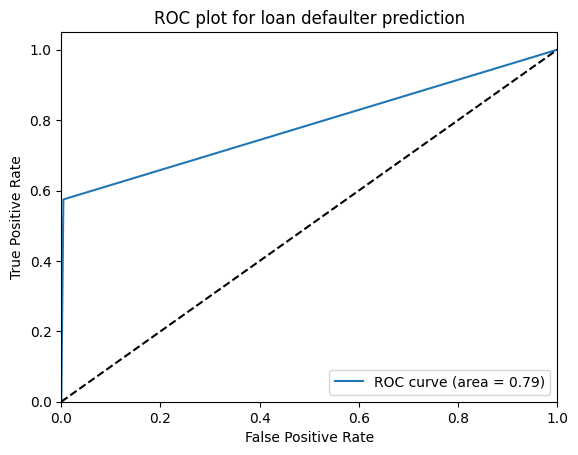

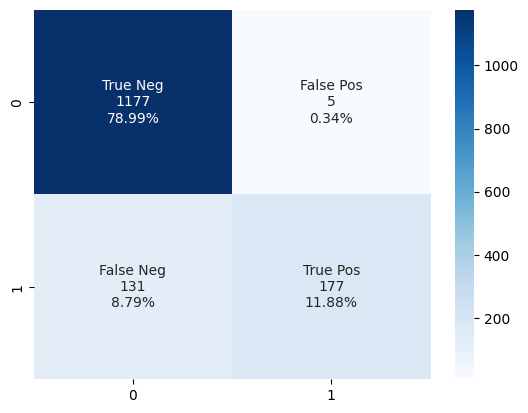



 
 
 

using dataset pruned: Dataset with all modifications
Accuracy on Training Dataset :  0.9997762863534676
Accuracy on CV Dataset :  0.9107382550335571


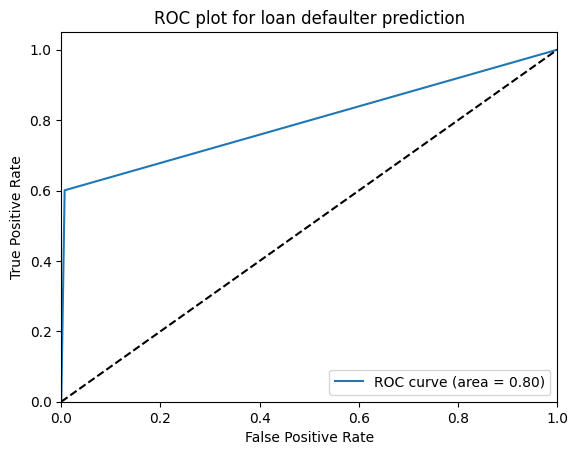

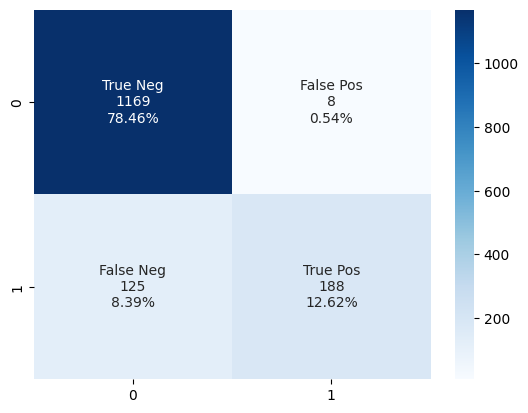



 
 
 

using dataset loan_only: basic but with LOAN transformed
Accuracy on Training Dataset :  1.0
Accuracy on CV Dataset :  0.9281879194630872


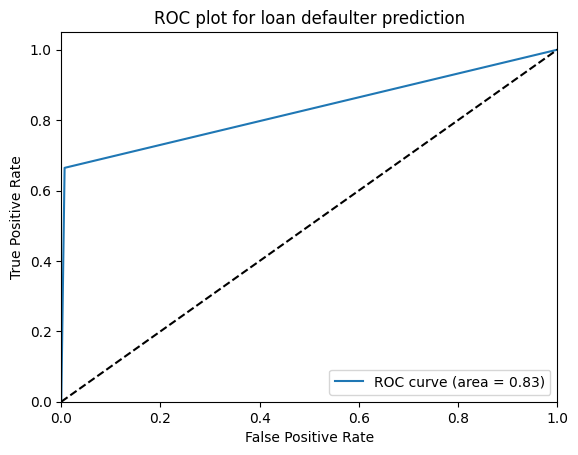

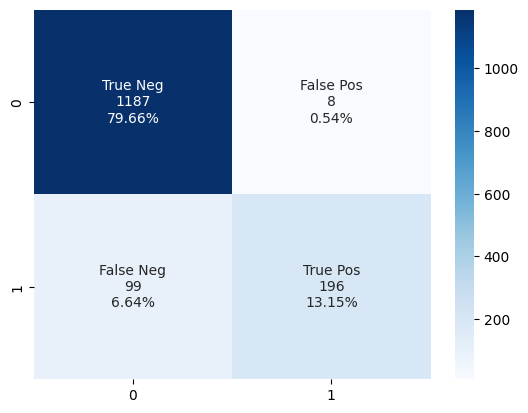



 
 
 

using dataset loan_pp: basic but more than LOAN Transformed
Accuracy on Training Dataset :  1.0
Accuracy on CV Dataset :  0.9201342281879195


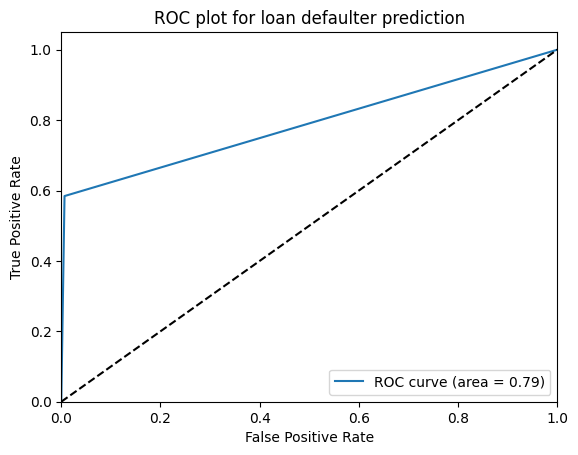

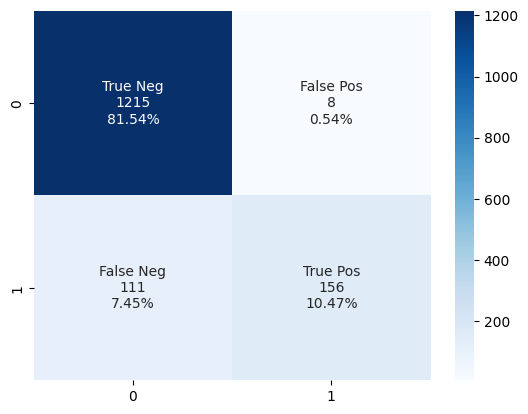

In [26]:
df_analytics = build_and_analyse([basic,pruned,loan_only,loan_pp],RandomForestClassifier)

We now compare visualisations over various metrics for which dataset logistic regression is best suited for:

In [29]:
df_analytics_plot = pd.DataFrame(df_analytics)

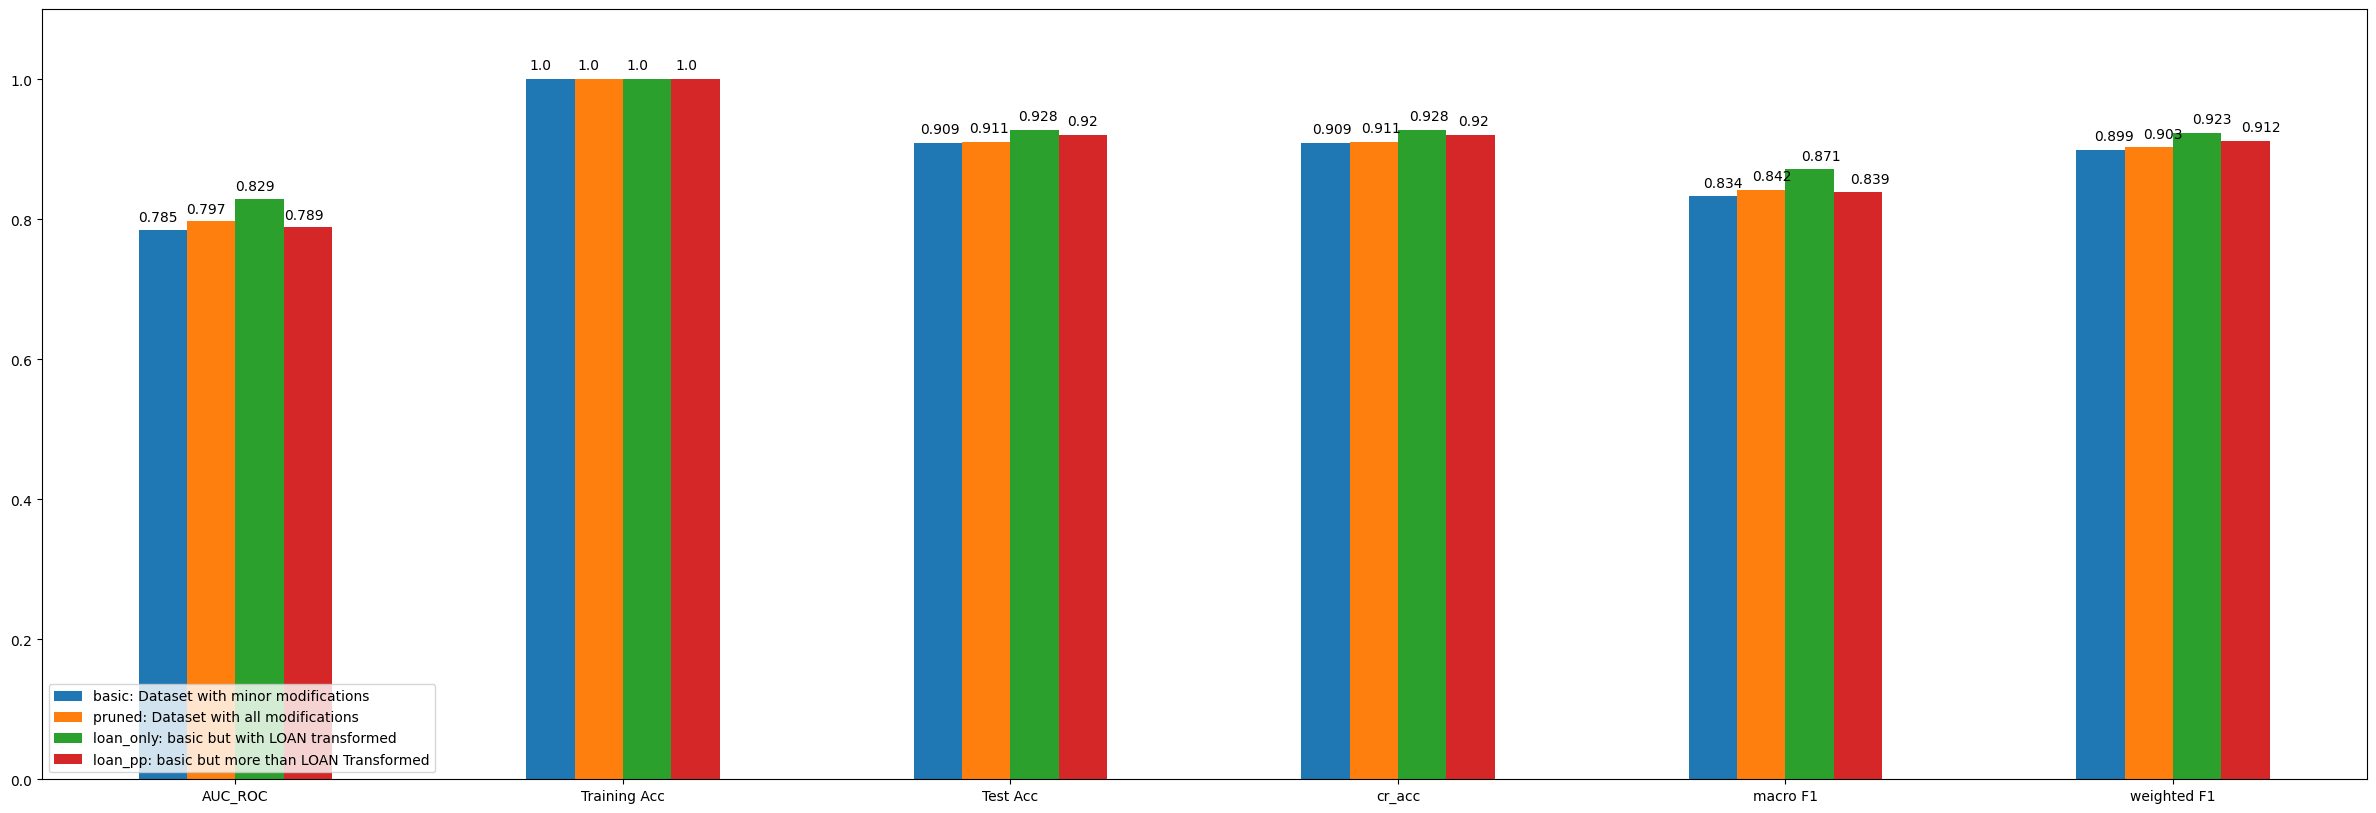

In [30]:
plottable_cols = list(set(df_analytics_plot.columns) - {'Model'})
# print(plottable_cols)
ax = df_analytics_plot[:-1].plot(kind='bar',figsize = (30,10),rot=0)
ax.set_ylim(0, 1.1)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.010, p.get_height() * 1.015),)
plt.legend(loc='lower left')
plt.show()


From the graphical representations, we can observe that the random forest model seems to perform the best, again on the loan_only dataset.Furthermore, we can also observe that in general the model performs vastly better compared to the logistic regression model, having a range of metric values from 0.91 to 0.80, and a significant high test score of 0.928.

# Analysing the Gradient Boost model

In [46]:
def build_and_analyse_xgb(dfs, modeltype,params):
    model = modeltype()
    print(str(type(model)).split(".")[-1][:-2])
    statistics = dict()
    for dataframe in dfs:
      scaled_features_df,y = preprocess(dataframe)
      x_train, x_test, y_train, y_test = train_test_split(scaled_features_df,y)
      model = modeltype()
      model.set_params(**params)
      model.fit(x_train,y_train)
      print("="*80)
      print('using dataset', dataframe.name)
      print("Accuracy on Training Dataset : ",model.score(x_train,y_train))
      print("Accuracy on CV Dataset : ",model.score(x_test,y_test))
      area, output_report = model_analysis(model,x_test,y_test,model.predict(x_test))
      print("="*80)
      print("\n \n \n \n")
      statistics[dataframe.name] = {
          'AUC_ROC':area,
          'Training Acc': model.score(x_train,y_train),
          'Test Acc': model.score(x_test,y_test),
          'cr_acc':output_report['accuracy'],
          'macro F1':output_report['macro avg']['f1-score'],
          'weighted F1':output_report['weighted avg']['f1-score'],
          'model': clone(model)}
    return statistics


['n_estimators__500', 'learning_rate__0.05', 'eval_metric__logloss', 'n_jobs__-1']
XGBClassifier
using dataset basic: Dataset with minor modifications
Accuracy on Training Dataset :  0.9937360178970918
Accuracy on CV Dataset :  0.9046979865771813


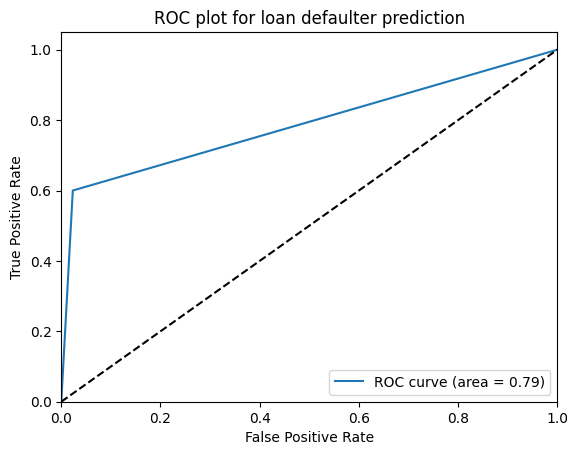

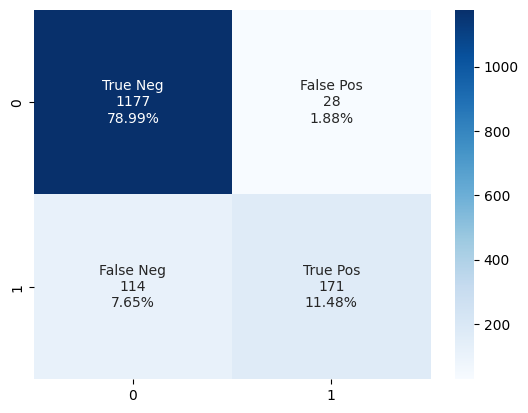



 
 
 

using dataset pruned: Dataset with all modifications
Accuracy on Training Dataset :  0.991275167785235
Accuracy on CV Dataset :  0.9241610738255034


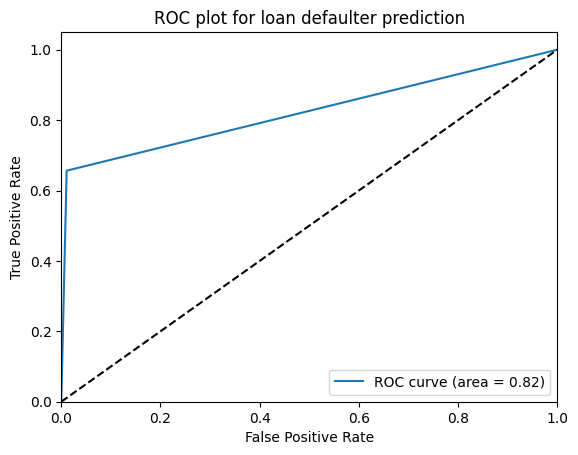

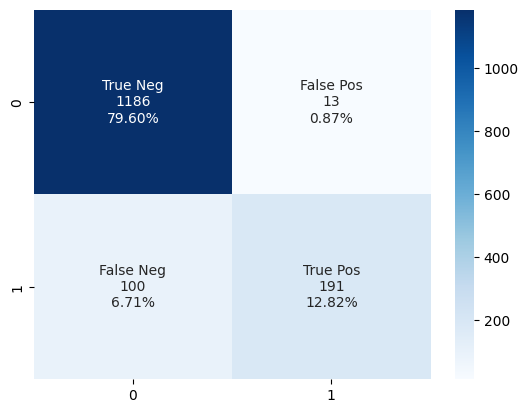



 
 
 

using dataset loan_only: basic but with LOAN transformed
Accuracy on Training Dataset :  0.9937360178970918
Accuracy on CV Dataset :  0.925503355704698


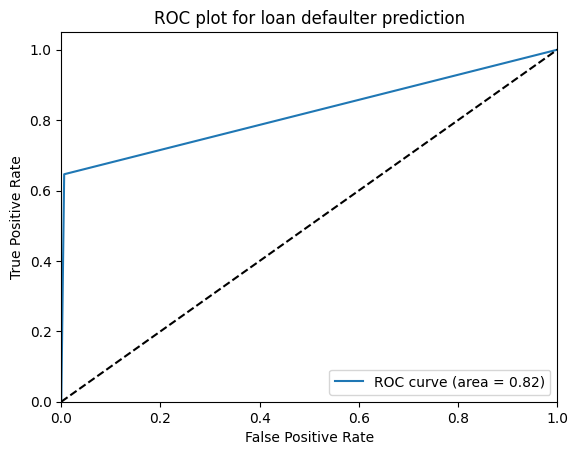

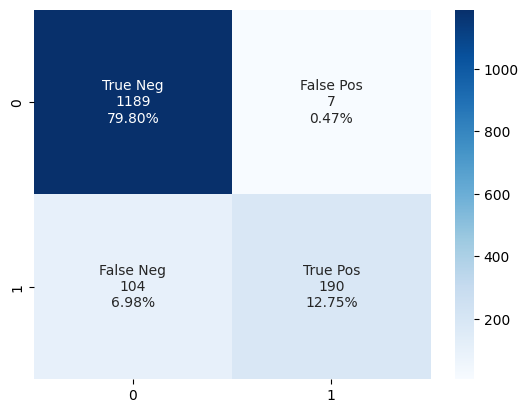



 
 
 

using dataset loan_pp: basic but more than LOAN Transformed
Accuracy on Training Dataset :  0.9932885906040269
Accuracy on CV Dataset :  0.9087248322147651


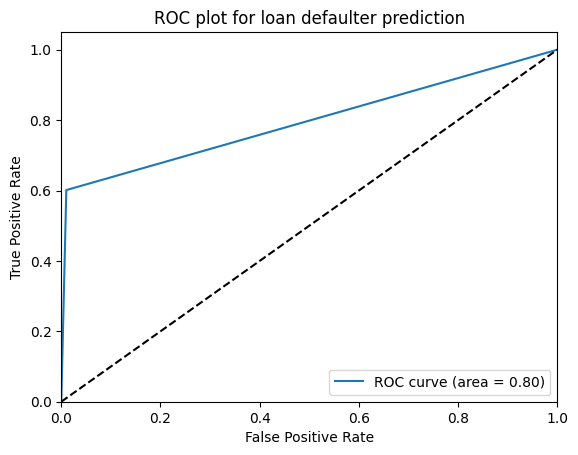

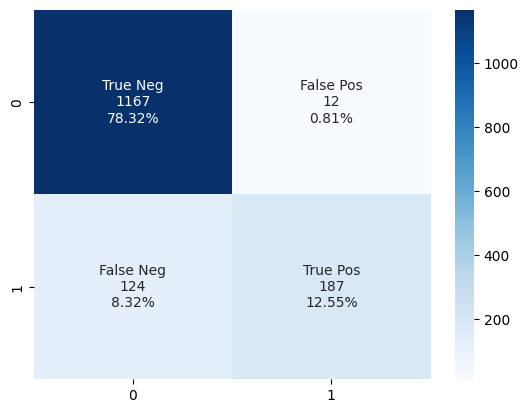

In [50]:
from xgboost import XGBClassifier
params = {'n_estimators' : 500,
                        'learning_rate' : 0.05,
                        'eval_metric' : "logloss",
                        'n_jobs' : -1}

params_list = [i+"__"+str(j) for i,j in params.items()]
print(params_list)
xgb_analytics = build_and_analyse_xgb([basic,pruned,loan_only,loan_pp],XGBClassifier,params)


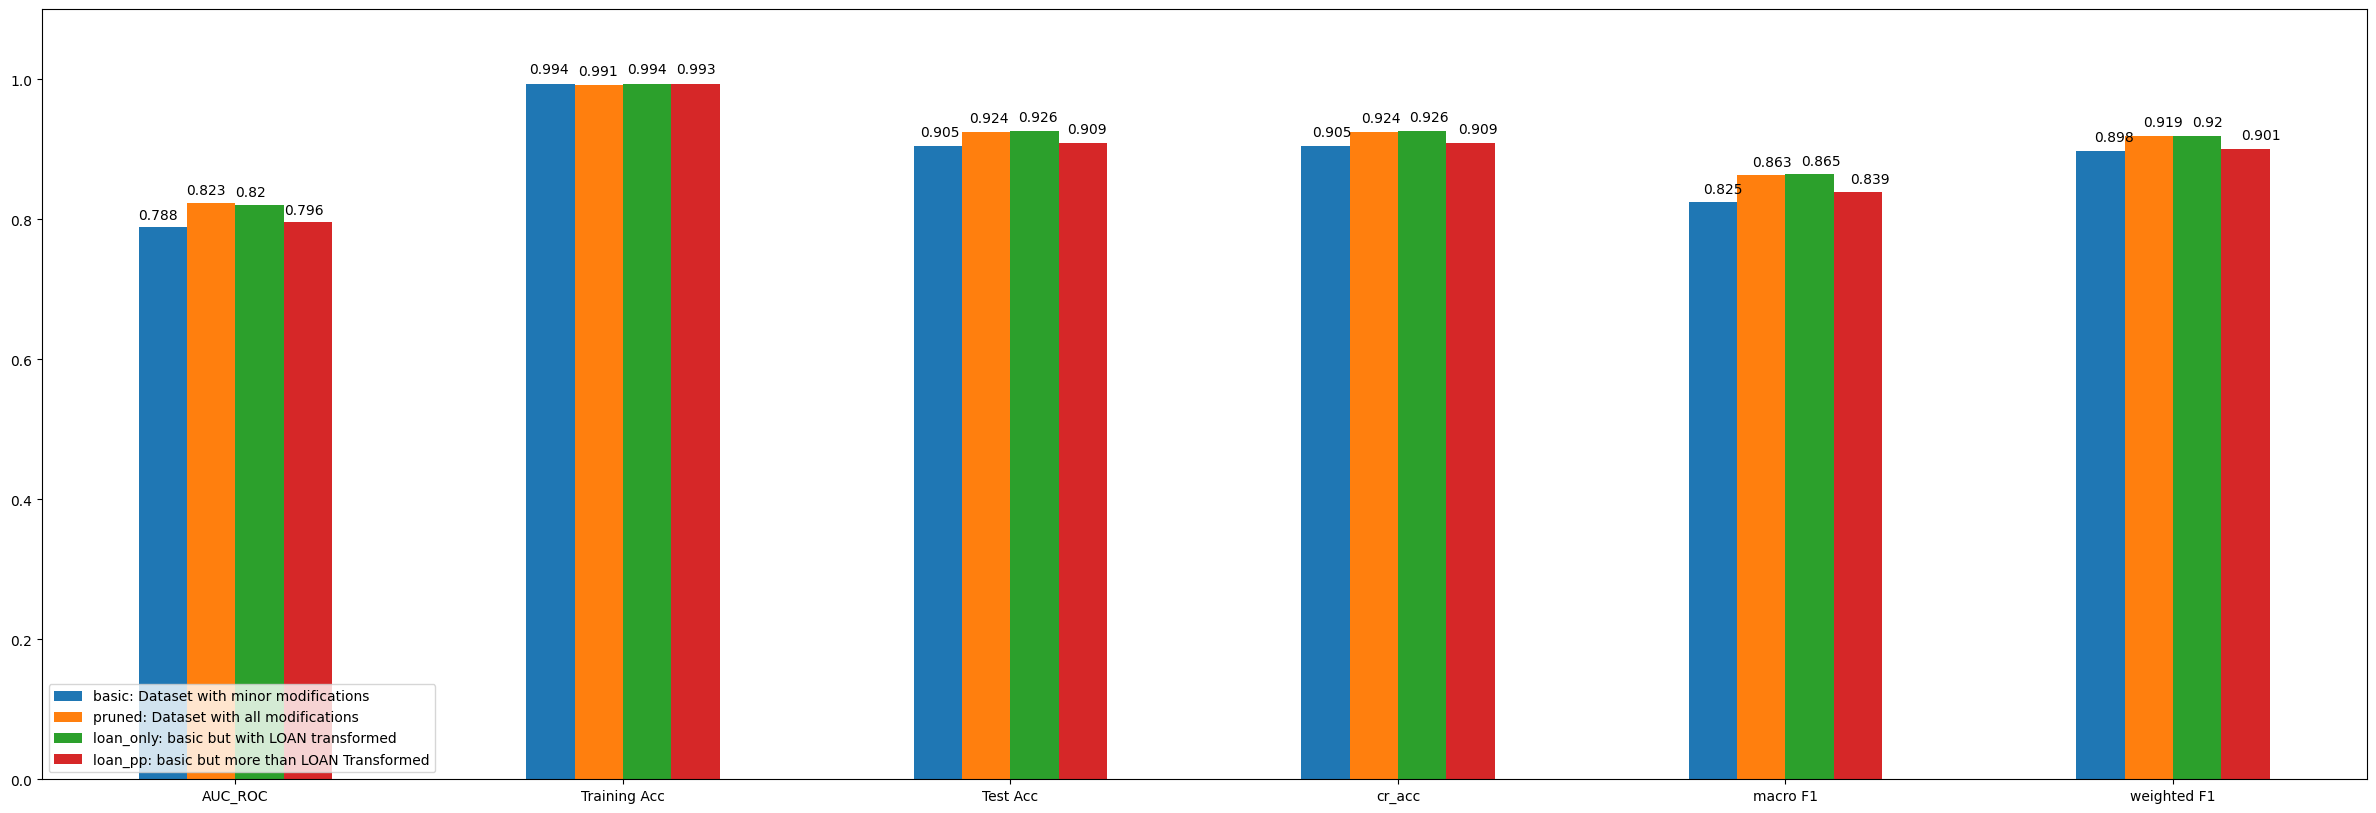

In [51]:

xgb_analytics_plot = pd.DataFrame(xgb_analytics)

plottable_cols = list(set(xgb_analytics_plot.columns) - {'Model'})
# print(plottable_cols)
ax = xgb_analytics_plot[:-1].plot(kind='bar',figsize = (30,10),rot=0)
ax.set_ylim(0, 1.1)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.010, p.get_height() * 1.015),)
plt.legend(loc='lower left')
plt.show()


The XGBoost model also performed as well, with values ranging from 0.82 to 0.92 over all metrics, and a test accuracy of 0.926 which does not fall far from the Random forest model, thus also indicating that it is a good model to use.

# Analysing the K Nearest Nighbours Classifier Model:

KNeighborsClassifier
using dataset basic: Dataset with minor modifications
Accuracy on Training Dataset :  0.9436241610738255
Accuracy on CV Dataset :  0.8805369127516779


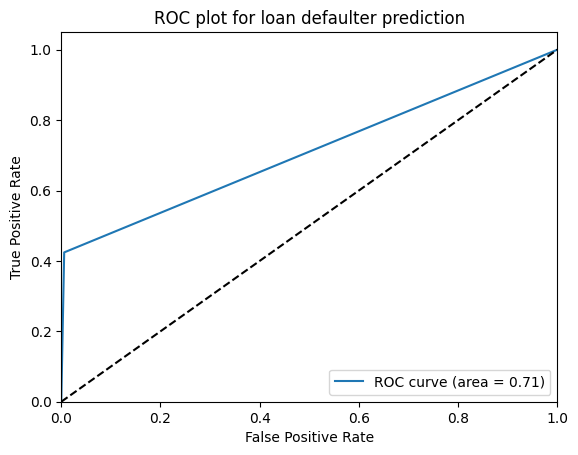

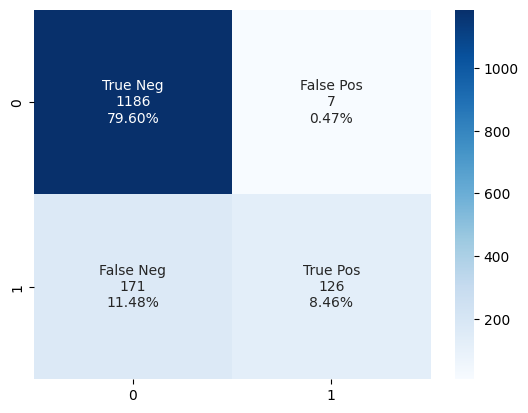



 
 
 

using dataset pruned: Dataset with all modifications
Accuracy on Training Dataset :  0.9395973154362416
Accuracy on CV Dataset :  0.8939597315436242


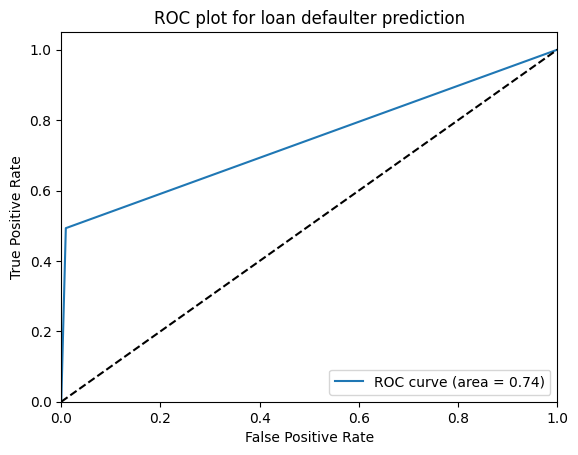

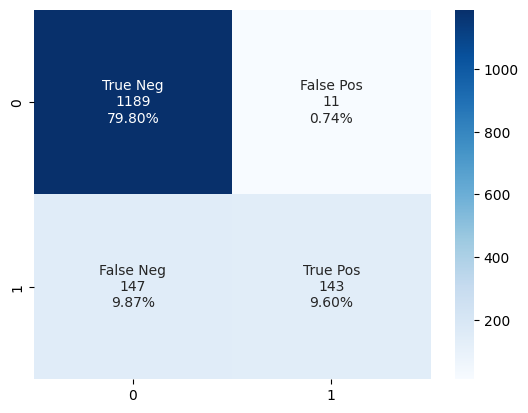



 
 
 

using dataset loan_only: basic but with LOAN transformed
Accuracy on Training Dataset :  0.9362416107382551
Accuracy on CV Dataset :  0.8959731543624161


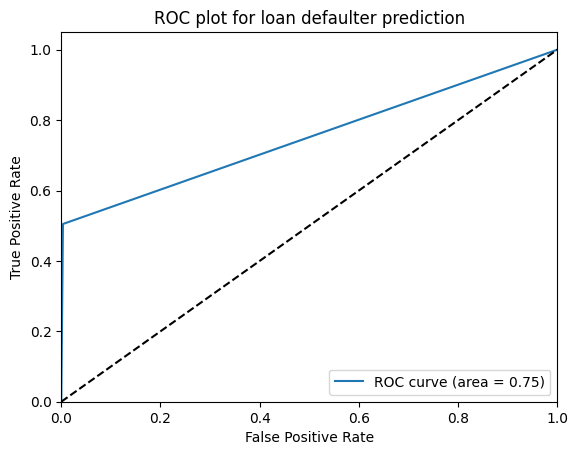

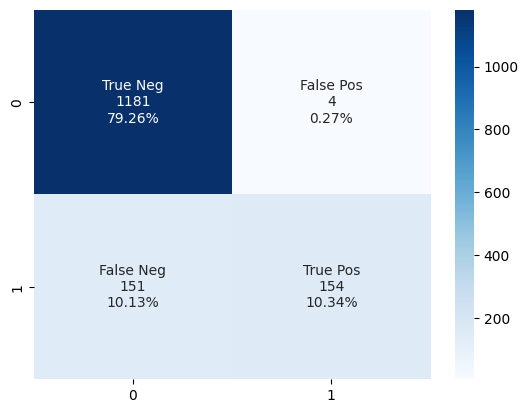



 
 
 

using dataset loan_pp: basic but more than LOAN Transformed
Accuracy on Training Dataset :  0.9404921700223714
Accuracy on CV Dataset :  0.8939597315436242


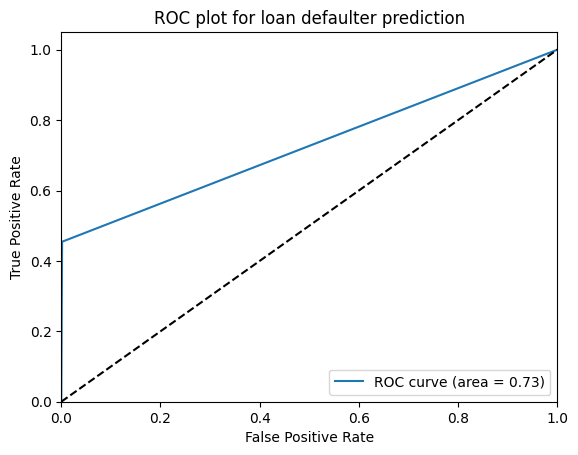

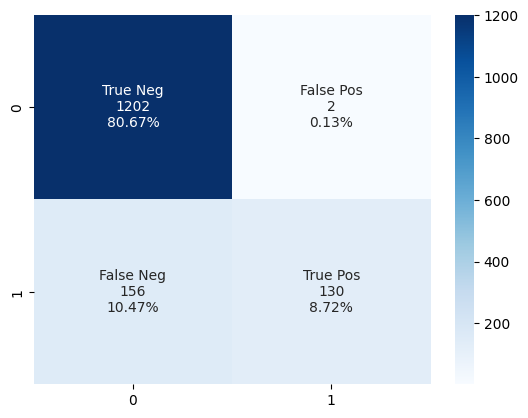

In [55]:
from sklearn.neighbors import KNeighborsClassifier
params = {'n_neighbors':3}
kn_analytics = build_and_analyse_xgb([basic,pruned,loan_only,loan_pp],KNeighborsClassifier,params)

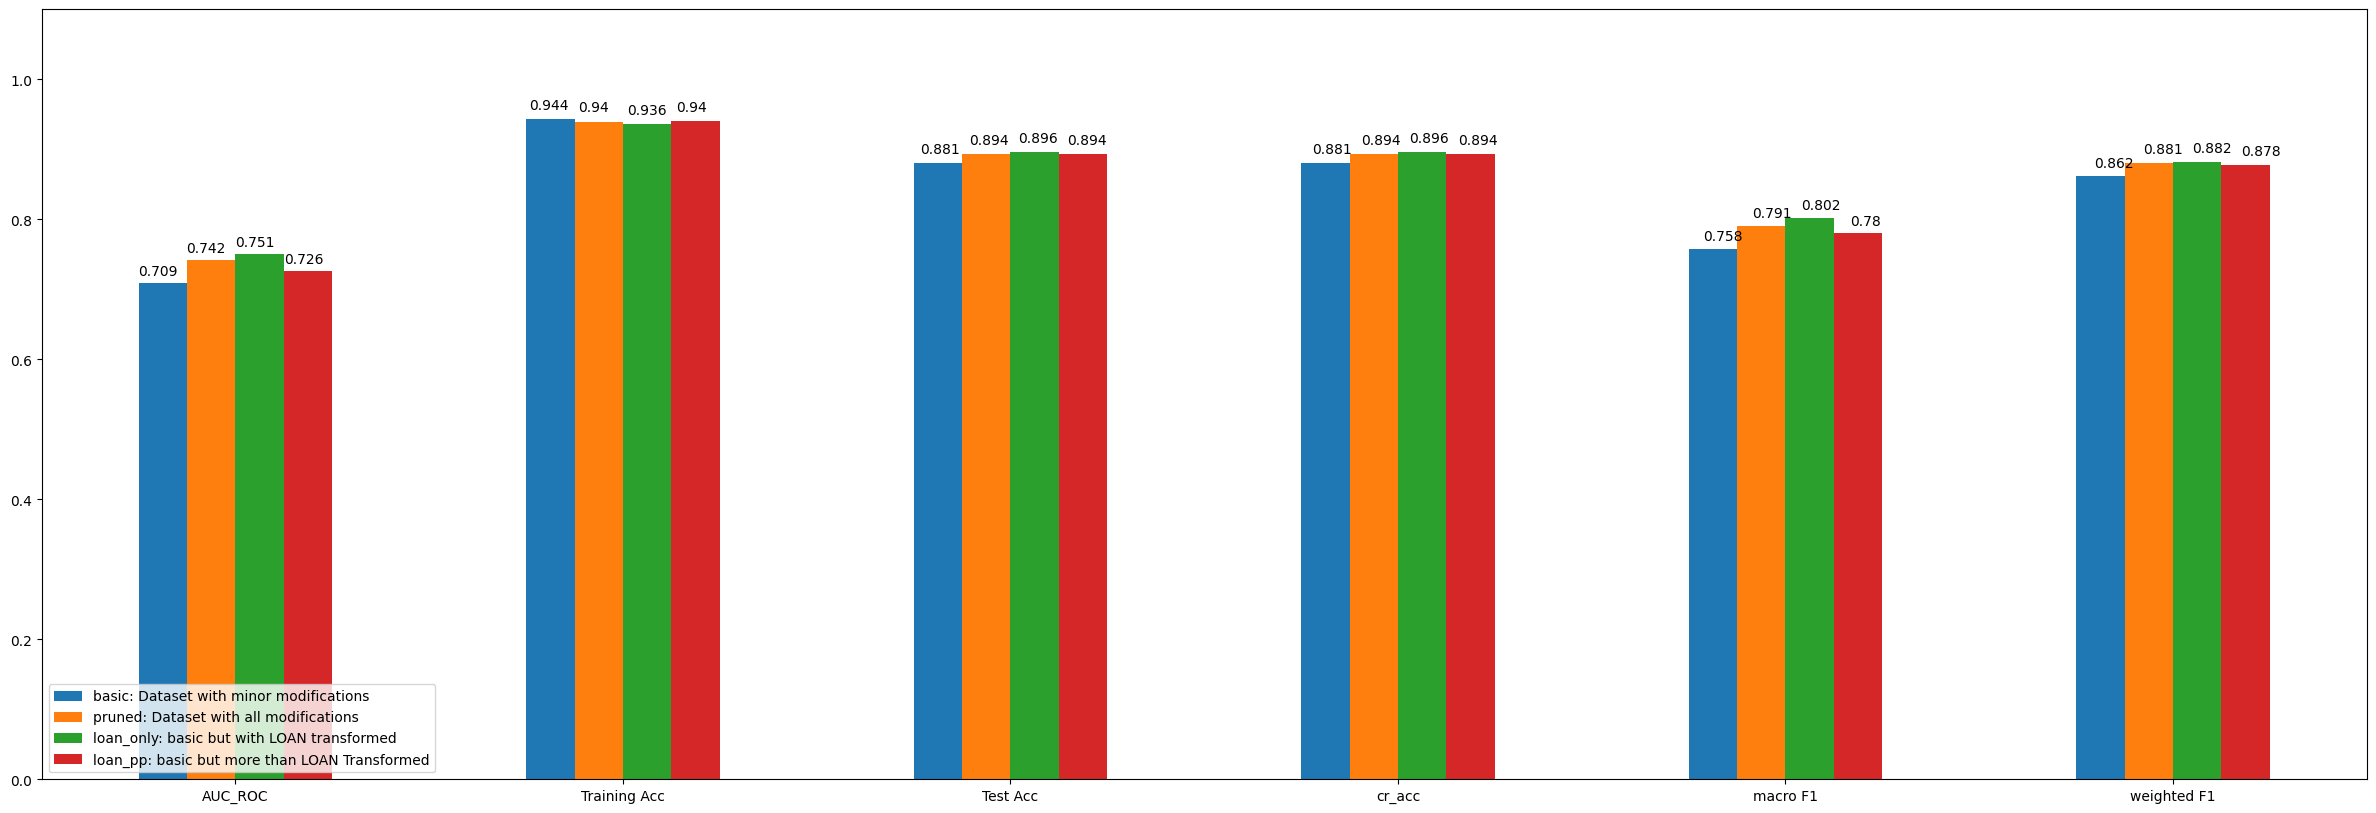

In [56]:

kn_analytics_plot = pd.DataFrame(kn_analytics)

plottable_cols = list(set(kn_analytics_plot.columns) - {'Model'})
# print(plottable_cols)
ax = kn_analytics_plot[:-1].plot(kind='bar',figsize = (30,10),rot=0)
ax.set_ylim(0, 1.1)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.010, p.get_height() * 1.015),)
plt.legend(loc='lower left')
plt.show()


we can observe that the k neighbours classifier enjoys a better AUC ROC value  of 0.7 despite its metrics overall being less than the two prior models.

# Analysing the Support Vector Classifier model:


SVC
using dataset basic: Dataset with minor modifications
Accuracy on Training Dataset :  0.8953020134228188
Accuracy on CV Dataset :  0.874496644295302


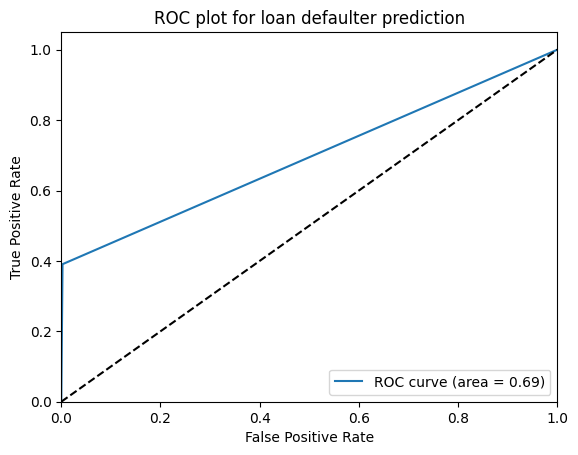

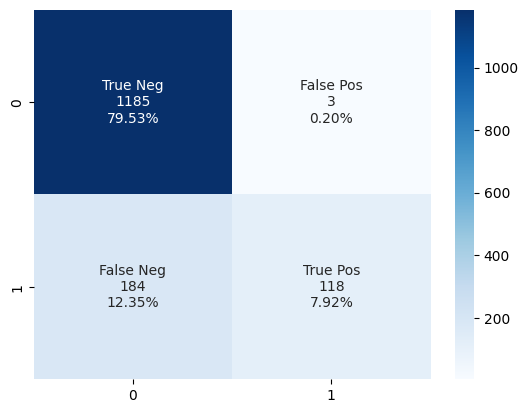



 
 
 

using dataset pruned: Dataset with all modifications
Accuracy on Training Dataset :  0.8973154362416107
Accuracy on CV Dataset :  0.8919463087248322


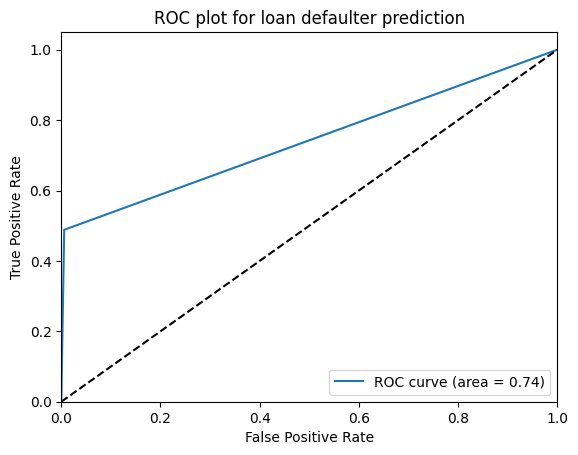

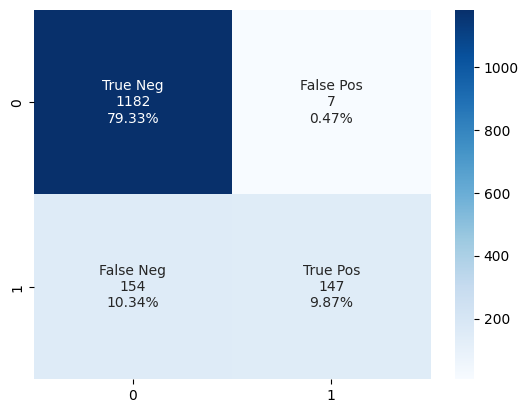



 
 
 

using dataset loan_only: basic but with LOAN transformed
Accuracy on Training Dataset :  0.8926174496644296
Accuracy on CV Dataset :  0.9013422818791946


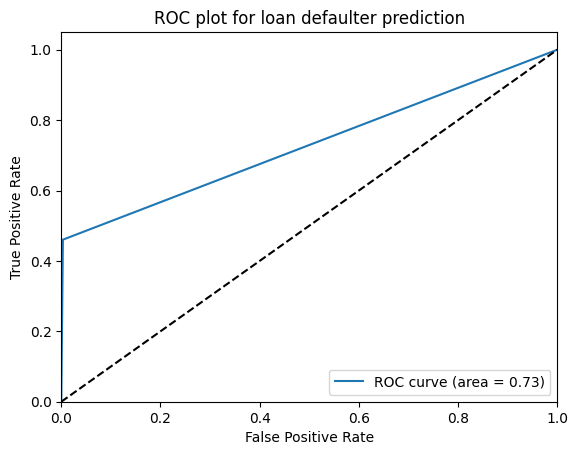

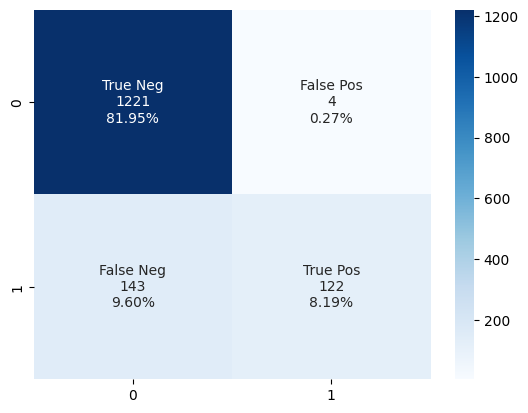



 
 
 

using dataset loan_pp: basic but more than LOAN Transformed
Accuracy on Training Dataset :  0.8984340044742729
Accuracy on CV Dataset :  0.8879194630872483


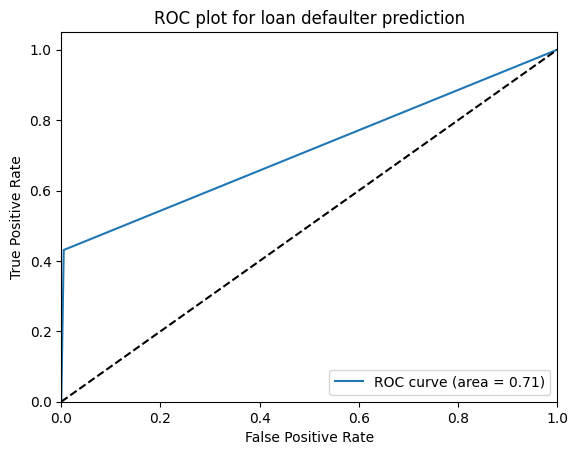

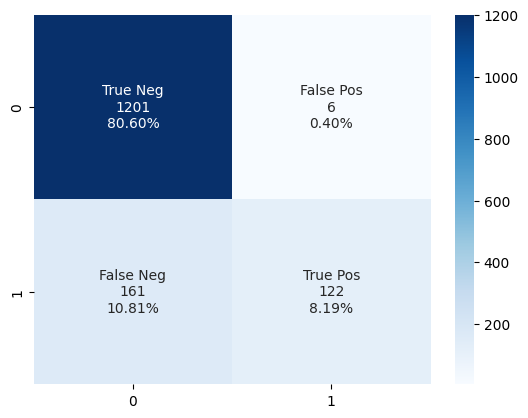

In [58]:
from sklearn.svm import SVC

svc_analytics = build_and_analyse([basic,pruned,loan_only,loan_pp],SVC)

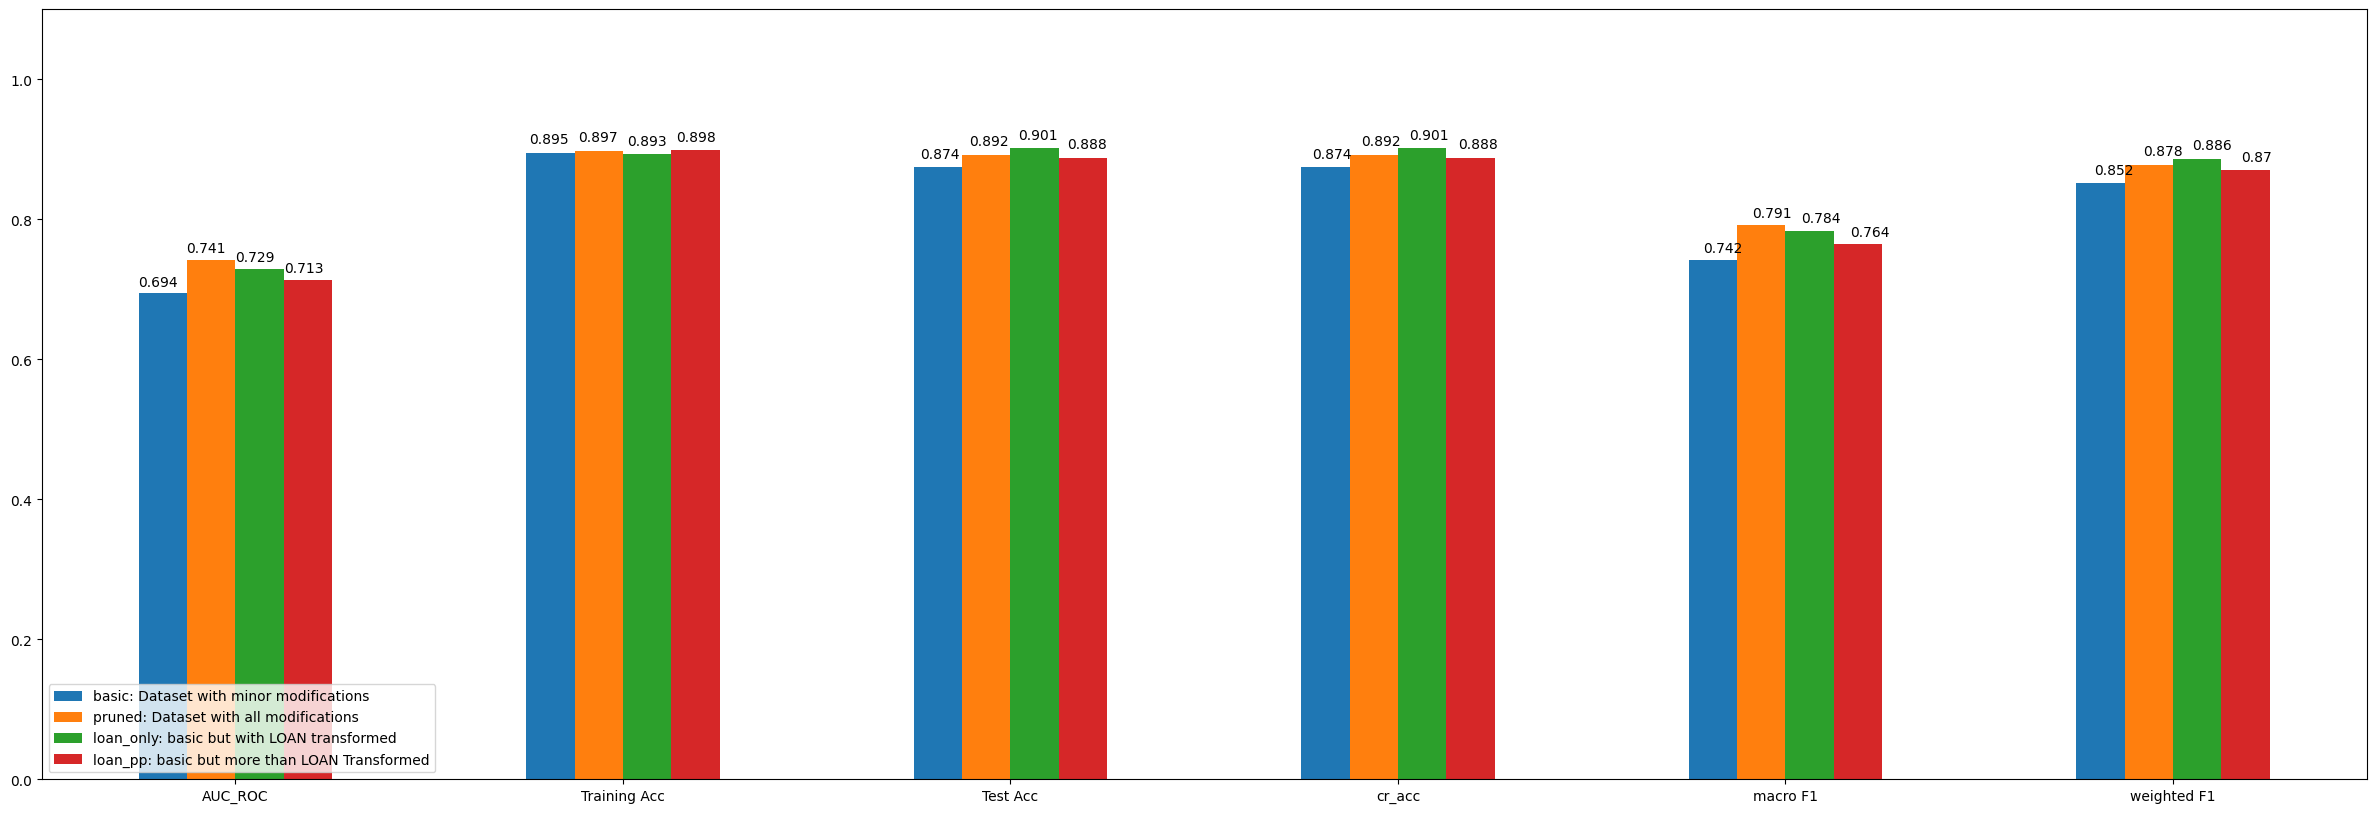

In [59]:

svc_analytics_plot = pd.DataFrame(svc_analytics)

plottable_cols = list(set(svc_analytics_plot.columns) - {'Model'})
# print(plottable_cols)
ax = svc_analytics_plot[:-1].plot(kind='bar',figsize = (30,10),rot=0)
ax.set_ylim(0, 1.1)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.010, p.get_height() * 1.015),)
plt.legend(loc='lower left')
plt.show()


With the following models, we can aggregate the results below:

In [61]:
df_analytics_plot # Random forest model

,basic: Dataset with minor modifications,pruned: Dataset with all modifications,loan_only: basic but with LOAN transformed,loan_pp: basic but more than LOAN Transformed
AUC_ROC,0.785223,0.796921,0.828856,0.788864
Training Acc,1.0,0.999776,1.0,1.0
Test Acc,0.908725,0.910738,0.928188,0.920134
cr_acc,0.908725,0.910738,0.928188,0.920134
macro F1,0.833915,0.842439,0.871222,0.838606
weighted F1,0.899299,0.902593,0.922957,0.912205
model,RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier()


In [63]:
xgb_analytics_plot

,basic: Dataset with minor modifications,pruned: Dataset with all modifications,loan_only: basic but with LOAN transformed,loan_pp: basic but more than LOAN Transformed
AUC_ROC,0.788382,0.822758,0.820203,0.795554
Training Acc,0.993736,0.991275,0.993736,0.993289
Test Acc,0.904698,0.924161,0.925503,0.908725
cr_acc,0.904698,0.924161,0.925503,0.908725
macro F1,0.82486,0.863122,0.864667,0.839136
weighted F1,0.897873,0.918824,0.919596,0.900772
model,"XGBClassifier(base_score=None, booster=None, c...","XGBClassifier(base_score=None, booster=None, c...","XGBClassifier(base_score=None, booster=None, c...","XGBClassifier(base_score=None, booster=None, c..."


In [64]:
kn_analytics_plot

,basic: Dataset with minor modifications,pruned: Dataset with all modifications,loan_only: basic but with LOAN transformed,loan_pp: basic but more than LOAN Transformed
AUC_ROC,0.709187,0.741968,0.750771,0.726442
Training Acc,0.943624,0.939597,0.936242,0.940492
Test Acc,0.880537,0.89396,0.895973,0.89396
cr_acc,0.880537,0.89396,0.895973,0.89396
macro F1,0.758121,0.790921,0.801823,0.780169
weighted F1,0.861597,0.880563,0.882497,0.877613
model,KNeighborsClassifier(n_neighbors=3),KNeighborsClassifier(n_neighbors=3),KNeighborsClassifier(n_neighbors=3),KNeighborsClassifier(n_neighbors=3)


In [62]:
svc_analytics_plot

,basic: Dataset with minor modifications,pruned: Dataset with all modifications,loan_only: basic but with LOAN transformed,loan_pp: basic but more than LOAN Transformed
AUC_ROC,0.694102,0.741242,0.728556,0.713062
Training Acc,0.895302,0.897315,0.892617,0.898434
Test Acc,0.874497,0.891946,0.901342,0.887919
cr_acc,0.874497,0.891946,0.901342,0.887919
macro F1,0.742394,0.791196,0.783631,0.764334
weighted F1,0.852087,0.877637,0.886454,0.870166
model,SVC(),SVC(),SVC(),SVC()


Thus, we will be using the Random Forest Model to prematurely label our dataset with their associated credit risks.

We will also be using the loan_only dataset as it has appeared to yield the best results prediction thus far.

In [65]:
scaled_features_df,y = preprocess(loan_only)
x_train, x_test, y_train, y_test = train_test_split(scaled_features_df,y)
model = RandomForestClassifier()
model.fit(x_train,y_train)

RandomForestClassifier()

In [66]:
risk_preds = model.predict_proba(scaled_features_df)

In [68]:
risk_preds = [i[1] for i in risk_preds]

In [69]:
loan_only['P_DEF_RISK'] = risk_preds

In [70]:
loan_only.to_csv('./loan_only_with_risk.csv')